<a href="https://colab.research.google.com/github/Julia891021/954/blob/main/faceshape_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import DataLoader
from torchvision import models
import torchvision.utils
import torch.utils.model_zoo as model_zoo


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 串接雲端硬碟

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/954')

Mounted at /content/drive


### Import Library

In [4]:
# Check data directory
os.listdir("FaceShape Dataset")

['training_set', 'testing_set', 'desktop.ini']

### Split train, val 

In [5]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    train, test = [], []
    for dset in os.listdir(data_dir):
        # check is directory
        subdir = os.path.join(data_dir, dset)
        if os.path.isdir(subdir):
            for label in os.listdir(subdir):
                imgdir = os.path.join(subdir, label)
                if os.path.isdir(imgdir):
                    for image_path in os.listdir(imgdir):
                        if image_path.endswith(".jpg"):
                            sample = {
                                "path": os.path.join(subdir, label, image_path),
                                "label": label
                            }
                            if dset == "training_set":
                                train.append(sample)
                            elif dset == "testing_set":
                                test.append(sample)
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

train_df, val_df, test_df = split_train_val("FaceShape Dataset")
test_df

,path,label
0,FaceShape Dataset/testing_set/Oblong/oblong (4...,Oblong
1,FaceShape Dataset/testing_set/Oblong/oblong (5...,Oblong
2,FaceShape Dataset/testing_set/Oblong/oblong (9...,Oblong
3,FaceShape Dataset/testing_set/Oblong/oblong (5...,Oblong
4,FaceShape Dataset/testing_set/Oblong/oblong (6...,Oblong
...,...,...
995,FaceShape Dataset/testing_set/Square/square (1...,Square
996,FaceShape Dataset/testing_set/Square/square (1...,Square
997,FaceShape Dataset/testing_set/Square/square (2...,Square
998,FaceShape Dataset/testing_set/Square/square (2...,Square


### Visualize some images and labels

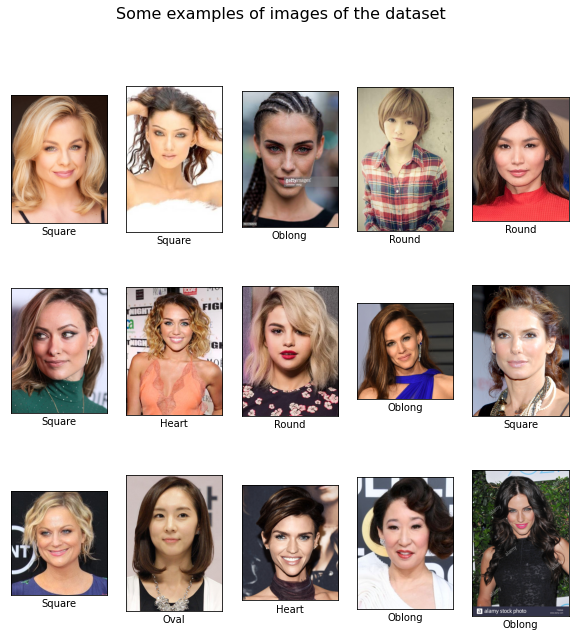

In [6]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [7]:
# Dataset
class FaceShapeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

   
    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### Inception v3


In [8]:
model_urls = {
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
}


def inception_v3(pretrained=False, **kwargs):
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        model = Inception3(**kwargs)
        model.load_state_dict(model_zoo.load_url(model_urls['inception_v3_google']))
        return model

    return Inception3(**kwargs)



class Inception3(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False):
        super(Inception3, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.Tensor(X.rvs(m.weight.data.numel()))
                values = values.view(m.weight.data.size())
                m.weight.data.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        if self.training and self.aux_logits:
            return x, aux
        return x


class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # 17 x 17 x 768
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # 5 x 5 x 768
        x = self.conv0(x)
        # 5 x 5 x 128
        x = self.conv1(x)
        # 1 x 1 x 768
        x = x.view(x.size(0), -1)
        # 768
        x = self.fc(x)
        # 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output,aux_output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_faceshape_model_inceptionv3.pth")
            print("Saved best faceshape model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

In [10]:
# Configs
class args:
    data_dir="FaceShape Dataset"
    batch_size=10
    n_epochs=20
    learning_rate=0.001
    debug=False

In [11]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    #transforms.ToTensor()
    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

### Start Training



In [12]:
import time
from datetime import timedelta
st = time.time()
print("-------- Start training --------")
model = inception_v3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

-------- Start training --------


Training Epoch 1:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.6731, Accuracy: 106/400 (26%)

Saved best faceshape model
Best accuracy: 26.5


Training Epoch 2:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.5812, Accuracy: 115/400 (29%)

Saved best faceshape model
Best accuracy: 28.75


Training Epoch 3:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.6378, Accuracy: 108/400 (27%)

Best accuracy: 28.75


Training Epoch 4:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.4746, Accuracy: 159/400 (40%)

Saved best faceshape model
Best accuracy: 39.75


Training Epoch 5:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.5585, Accuracy: 144/400 (36%)

Best accuracy: 39.75


Training Epoch 6:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.6758, Accuracy: 133/400 (33%)

Best accuracy: 39.75


Training Epoch 7:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.7252, Accuracy: 147/400 (37%)

Best accuracy: 39.75


Training Epoch 8:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.2600, Accuracy: 190/400 (48%)

Saved best faceshape model
Best accuracy: 47.5


Training Epoch 9:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.6711, Accuracy: 136/400 (34%)

Best accuracy: 47.5


Training Epoch 10:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.3903, Accuracy: 199/400 (50%)

Saved best faceshape model
Best accuracy: 49.75


Training Epoch 11:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.3993, Accuracy: 184/400 (46%)

Best accuracy: 49.75


Training Epoch 12:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.4031, Accuracy: 182/400 (46%)

Best accuracy: 49.75


Training Epoch 13:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.4860, Accuracy: 183/400 (46%)

Best accuracy: 49.75


Training Epoch 14:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.1695, Accuracy: 227/400 (57%)

Saved best faceshape model
Best accuracy: 56.75


Training Epoch 15:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.2566, Accuracy: 227/400 (57%)

Best accuracy: 56.75


Training Epoch 16:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.2201, Accuracy: 223/400 (56%)

Best accuracy: 56.75


Training Epoch 17:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.5830, Accuracy: 218/400 (54%)

Best accuracy: 56.75


Training Epoch 18:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Square/square (84).jpg
Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg


Validation Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.5137, Accuracy: 211/400 (53%)

Best accuracy: 56.75


Training Epoch 19:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 1.1898, Accuracy: 239/400 (60%)

Saved best faceshape model
Best accuracy: 59.75


Training Epoch 20:   0%|          | 0/360 [00:00<?, ?it/s]

Error load image FaceShape Dataset/training_set/Heart/heart (633).jpg
Error load image FaceShape Dataset/training_set/Square/square (84).jpg


Validation Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]


Validation set: Average loss: 0.8586, Accuracy: 285/400 (71%)

Saved best faceshape model
Best accuracy: 71.25
-------- End training, time taken: 1:00:43


### Load Pretrined model

In [13]:
# path = '/content/drive/Shareddrives/954/best_faceshape_model_inceptionv3.pth'
# model = inception_v3().to(device)
# model.load_state_dict(torch.load(path))

### Predict on test set

In [14]:
test_ds = FaceShapeDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true += target.view(-1).tolist()
      y_pred += pred.view(-1).tolist()
        
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 0.9213, Accuracy: 689/1000 (69%)

              precision    recall  f1-score   support

       Heart       0.68      0.60      0.64       200
      Oblong       0.82      0.72      0.77       200
        Oval       0.66      0.53      0.59       200
       Round       0.58      0.78      0.66       200
      Square       0.75      0.81      0.78       200

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


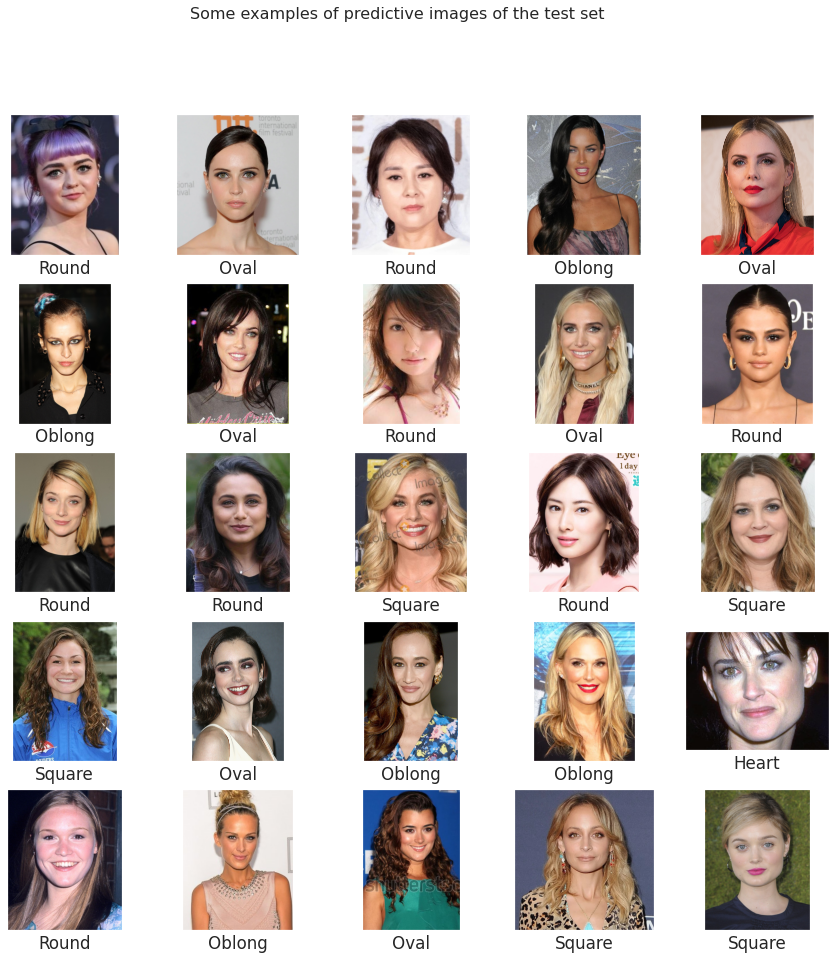

In [17]:
def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of predictive images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_pred[idx])
    plt.show()

display_examples()